In [1]:
import pandas as pd
import numpy as np
import sklearn.discriminant_analysis as skl_da
import sklearn.model_selection as skl_ms
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
#data = pd.read_csv('../data/training_data.csv')

# Load new dataset
data = pd.read_csv('../data/data_copy.csv')

X = data.drop('increase_stock', axis=1) 
y = data['increase_stock'] 
X_train, X_test, y_train, y_test = skl_ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
lda = skl_da.LinearDiscriminantAnalysis().fit(X_train,y_train)
y_pred_lda = lda.predict(X_test)
lda.score(X_test,y_test)
print(classification_report(y_test, y_pred_lda))


                  precision    recall  f1-score   support

high_bike_demand       0.52      0.62      0.56        50
 low_bike_demand       0.93      0.89      0.91       270

        accuracy                           0.85       320
       macro avg       0.72      0.76      0.74       320
    weighted avg       0.86      0.85      0.86       320


In [21]:
len(lda.coef_[0])

19

In [22]:
qda = skl_da.QuadraticDiscriminantAnalysis().fit(X_train,y_train)
y_pred_qda = qda.predict(X_test)
qda.score(X_test,y_test)
print(classification_report(y_test, y_pred_qda))


                  precision    recall  f1-score   support

high_bike_demand       0.34      0.70      0.46        50
 low_bike_demand       0.93      0.75      0.83       270

        accuracy                           0.74       320
       macro avg       0.64      0.72      0.64       320
    weighted avg       0.84      0.74      0.77       320


/Users/finnvaughankraska/IdeaProjects/BIKES_SML/venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [23]:
acc_lda = []
acc_qda = []
kf = skl_ms.KFold(n_splits=10, shuffle=True)
for i, (train_index, test_index) in enumerate(kf.split(data)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    lda_kf = skl_da.LinearDiscriminantAnalysis().fit(X_train,y_train)
    acc_lda.append(lda_kf.score(X_test,y_test))
    y_pred_lda_kf = lda_kf.predict(X_test)
    #print("LDA:")
    #print(classification_report(y_test, y_pred_lda_kf))

    qda_kf = skl_da.QuadraticDiscriminantAnalysis().fit(X_train,y_train)
    acc_qda.append(qda_kf.score(X_test,y_test))
    y_pred_qda_kf = qda_kf.predict(X_test)
    #print("QDA:")
    #print(classification_report(y_test, y_pred_qda_kf))

    
acc_lda = np.mean(acc_lda)
acc_qda = np.mean(acc_qda)

print(acc_lda, acc_qda)




/Users/finnvaughankraska/IdeaProjects/BIKES_SML/venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/finnvaughankraska/IdeaProjects/BIKES_SML/venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/finnvaughankraska/IdeaProjects/BIKES_SML/venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/finnvaughankraska/IdeaProjects/BIKES_SML/venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/finnvaughankraska/IdeaProjects/BIKES_SML/venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.8737499999999999 0.748125


# Finn see results with feature pipline (one hot categoricals)

In [2]:
import pandas as pd
from feature_creation import data_copy
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from os import cpu_count
import numpy as np

In [3]:
data_copy['increase_stock'] = data_copy['increase_stock'].apply(lambda entity: 1 if entity == 'high_bike_demand' else 0)
data_copy['increase_stock'] = data_copy['increase_stock'].astype('int')
data_copy.describe()

,holiday,weekday,summertime,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility,increase_stock,daytime,rushhour,weather_score,weather_score_daytime
count,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.033125,0.710000,0.64375,15.210313,7.750750,63.927844,0.122042,0.042713,13.082500,64.322375,15.344125,0.180000,0.543750,0.205625,0.180000,0.127378
std,0.179019,0.453904,0.47904,9.264785,10.026459,19.079419,0.920600,0.421198,7.756652,32.748869,2.323737,0.384308,0.498238,0.404284,0.184322,0.189459
min,0.000000,0.000000,0.00000,-9.100000,-18.400000,15.850000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,-0.239787,-0.160192
25%,0.000000,0.000000,0.00000,7.700000,-0.800000,47.845000,0.000000,0.000000,7.500000,28.800000,16.000000,0.000000,0.000000,0.000000,0.049945,0.000000
50%,0.000000,1.000000,1.00000,15.500000,8.300000,65.175000,0.000000,0.000000,12.300000,79.300000,16.000000,0.000000,1.000000,0.000000,0.154343,0.000000
75%,0.000000,1.000000,1.00000,23.200000,16.800000,79.955000,0.000000,0.000000,17.600000,92.800000,16.000000,0.000000,1.000000,0.000000,0.278779,0.225751
max,1.000000,1.000000,1.00000,35.600000,24.300000,99.890000,25.871000,6.710000,43.800000,100.000000,16.000000,1.000000,1.000000,1.000000,0.956538,0.956538


In [4]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   hour_of_day            1600 non-null   category
 1   day_of_week            1600 non-null   category
 2   month                  1600 non-null   category
 3   holiday                1600 non-null   int64   
 4   weekday                1600 non-null   int64   
 5   summertime             1600 non-null   int64   
 6   temp                   1600 non-null   float64 
 7   dew                    1600 non-null   float64 
 8   humidity               1600 non-null   float64 
 9   precip                 1600 non-null   float64 
 10  snowdepth              1600 non-null   float64 
 11  windspeed              1600 non-null   float64 
 12  cloudcover             1600 non-null   float64 
 13  visibility             1600 non-null   float64 
 14  increase_stock         1600 non-null   i

In [28]:
X = data_copy.drop('increase_stock', axis=1)
Y = data_copy['increase_stock']

model = QuadraticDiscriminantAnalysis()

pre = ColumnTransformer(
    [('cat',OneHotEncoder(),list(X.select_dtypes('category').columns))],
    remainder='passthrough')

qda = Pipeline([
    ('pre', pre),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scale',StandardScaler()),
    ('PCA', PCA(n_components=4)),
    ('classifier', model)
])

In [29]:
y_hats = cross_val_predict(qda, X=X, y=Y, n_jobs=cpu_count())
print(classification_report(Y,y_hats))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1312
           1       0.68      0.67      0.67       288

    accuracy                           0.88      1600
   macro avg       0.80      0.80      0.80      1600
weighted avg       0.88      0.88      0.88      1600


In [16]:
qda.fit(X,Y)
qda[2].get_feature_names_out()

array(['x0', 'x1', 'x2', ..., 'x1766', 'x1767', 'x1768'], dtype=object)

<Axes: >

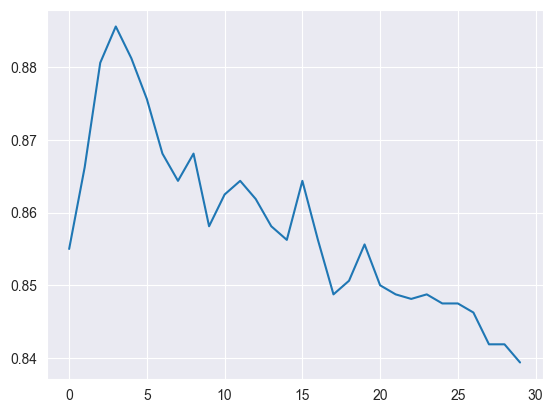

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
accuracy_array = []
for i in range(0,30):
    pipe = Pipeline([
        ('pre', pre),
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scale',StandardScaler()),
        ('PCA', PCA(n_components=i+1)),
        ('classifier', model)
    ])
    cvr = cross_val_score(pipe, X,Y, cv=kf, scoring='accuracy', n_jobs=cpu_count())
    accuracy_array.append(np.mean(cvr))
import seaborn as sns
sns.lineplot(accuracy_array)

In [18]:
accuracy_array.index(np.max(accuracy_array))

3